In [1]:
# !pip install -e .

In [2]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import jax.numpy as jnp
from random import randint
import jax
from jax.scipy.spatial.transform import Rotation as R

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

from typing import NamedTuple
class Intrinsics(NamedTuple):
    height: int
    width: int
    fx: float
    fy: float
    cx: float
    cy: float
    near: float
    far: float


intrinsics = Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)



In [4]:
default_seed = 1222
gt_seed = 1208

In [5]:
from diff_gaussian_rasterization import _C
import jax.numpy as jnp
import jax
import functools
from jax import core, dtypes
from jax.core import ShapedArray
from jax.interpreters import batching, mlir, xla
from jax.lib import xla_client
import numpy as np
from jaxlib.hlo_helpers import custom_call
from tqdm import tqdm
for _name, _value in _C.registrations().items():
    print(_name)
    xla_client.register_custom_call_target(_name, _value, platform="gpu")

rasterize_gaussians_fwd


In [10]:


# XLA array layout in memory
def default_layouts(*shapes):
    return [range(len(shape) - 1, -1, -1) for shape in shapes]
    
@functools.lru_cache(maxsize=None)
def _build_rasterize_gaussians_fwd_primitive():
    # For JIT compilation we need a function to evaluate the shape and dtype of the
    # outputs of our op for some given inputs

    def _rasterize_fwd_abstract(
            bg,
            means3D,
            colors_precomp,
            opacities,
            scales,
            rotations,
            cov3Ds_precomp, 
            viewmatrix,
            projmatrix,
            sh,
            campos,
            image_empty,
            tanfovx, tanfovy, image_height, image_width,  sh_degree,
        ):

        # float *out_num_rendered = reinterpret_cast<float *> (buffers[11]);
        # float *out_color = reinterpret_cast<float *> (buffers[12]);
        # int *radii = reinterpret_cast<int *> (buffers[13]);
        # float *geomBuffer = reinterpret_cast<float *> (buffers[14]);
        # float *binningBuffer = reinterpret_cast<float *> (buffers[15]);
        # float *imgBuffer = reinterpret_cast<float *> (buffers[16]);

        dtype = dtypes.canonicalize_dtype(means3D.dtype)
        num_gaussians, _ = means3D.shape
        _image_height, _image_width = image_empty.shape[:2]

        GEOM_BUFFER_SIZE = int(1e6)
        BINNING_BUFFER_SIZE = int(1e7)
        IMG_BUFFER_SIZE = int(1e6)

        return [ShapedArray((1,), dtypes.canonicalize_dtype(jnp.int32)),
                ShapedArray((3, _image_height, _image_width),  dtypes.canonicalize_dtype(jnp.float32)),
                ShapedArray((num_gaussians,), dtypes.canonicalize_dtype(jnp.int32)),
                ShapedArray((GEOM_BUFFER_SIZE,),  dtypes.canonicalize_dtype(jnp.float32)),
                ShapedArray((BINNING_BUFFER_SIZE,),  dtypes.canonicalize_dtype(jnp.float32)),
                ShapedArray((IMG_BUFFER_SIZE,),  dtypes.canonicalize_dtype(jnp.float32)),
        ]
    # Provide an MLIR "lowering" of the rasterize primitive.
    def _rasterize_fwd_lowering(ctx,
            bg,
            means3D,
            colors_precomp,
            opacities,
            scales,
            rotations,
            cov3Ds_precomp, 
            viewmatrix,
            projmatrix,
            sh,
            campos,
            image_empty,
            tanfovx, tanfovy, image_height, image_width,  sh_degree
    ):
        
        num_gaussians = ctx.avals_in[1].shape[0]
        # _image_height, _image_width = image_empty.shape[:2]
        
        # jax.debug.print("🤯 {image_height} 🤯", image_height=image_height)
        # jax.debug.print("🤯 {image_width} 🤯", image_width=image_width)
        # jax.debug.print("🤯 {sh_degree} 🤯", sh_degree=sh_degree)
        # jax.debug.print("🤯 {tanfovx} 🤯", tanfovx=tanfovx)

        opaque = _C.build_gaussian_rasterize_fwd_descriptor(
            # image_height,image_width, sh_degree, num_gaussians, tanfovx, tanfovy
            200, 200, 0, num_gaussians, 0.7499999908297853, 0.7499999908297853
        )

        op_name = "rasterize_gaussians_fwd"

        operands = [bg, means3D, colors_precomp, opacities, scales, rotations,
                      cov3Ds_precomp, viewmatrix, projmatrix, sh, campos]

        operands_ctx = ctx.avals_in[:11]

        GEOM_BUFFER_SIZE = int(1e6)
        BINNING_BUFFER_SIZE = int(1e7)
        IMG_BUFFER_SIZE = int(1e6)
        output_shapes = [
            (1,), (200, 200, 3), (num_gaussians,), (GEOM_BUFFER_SIZE,), (BINNING_BUFFER_SIZE,), (IMG_BUFFER_SIZE,)]
        image_height, image_width = 200, 200

        # [
        # ShapedArray((1,), jnp.int32),
        #         ShapedArray((_image_height, _image_width, 3), jnp.float32),
        #         ShapedArray((num_gaussians,), jnp.int32),
        #         ShapedArray((GEOM_BUFFER_SIZE,), jnp.float32),
        #         ShapedArray((BINNING_BUFFER_SIZE,), jnp.float32),
        #         ShapedArray((IMG_BUFFER_SIZE,), jnp.float32),
        # ]
        result_types = [
            mlir.ir.RankedTensorType.get(
                [1],
                mlir.dtype_to_ir_type(np.dtype(np.int32))),
            mlir.ir.RankedTensorType.get(
                [3, image_height, image_width],
                mlir.dtype_to_ir_type(np.dtype(np.float32))),
            mlir.ir.RankedTensorType.get(
                [num_gaussians],
                mlir.dtype_to_ir_type(np.dtype(np.int32))),
            mlir.ir.RankedTensorType.get(
                [GEOM_BUFFER_SIZE],
                mlir.dtype_to_ir_type(np.dtype(np.float32))),
            mlir.ir.RankedTensorType.get(
                [BINNING_BUFFER_SIZE],
                mlir.dtype_to_ir_type(np.dtype(np.float32))),
            mlir.ir.RankedTensorType.get(
                [IMG_BUFFER_SIZE],
                mlir.dtype_to_ir_type(np.dtype(np.float32))),
        ]

        return custom_call(
            op_name,
            # Output types
            result_types=result_types,
            # The inputs:
            operands=operands,
            backend_config=opaque,
            operand_layouts=default_layouts(*[i.shape for i in operands_ctx]),
            result_layouts=default_layouts(*output_shapes),
        ).results

        return custom_call(
            op_name,
            # Output types
            result_types=[out_shp_dtype, out_db_shp_dtype],
            # The inputs:
            operands=[attr, rast_out, tri, rast_db, diff_attrs],
            backend_config=opaque,
            operand_layouts=default_layouts(attr_aval.shape, rast_out_aval.shape, tri_aval.shape, rast_db_aval.shape, diff_attr_aval.shape),
            result_layouts=default_layouts((num_images, height, width, num_attributes,), (num_images, height, width, num_attributes,)),
        ).results
    # *********************************************
    # *  REGISTER THE OP WITH JAX  *
    # *********************************************
    _rasterize_prim = core.Primitive(f"my_primitive")
    _rasterize_prim.multiple_results = True
    _rasterize_prim.def_impl(functools.partial(xla.apply_primitive, _rasterize_prim))
    _rasterize_prim.def_abstract_eval(_rasterize_fwd_abstract)

    # # Connect the XLA translation rules for JIT compilation
    mlir.register_lowering(_rasterize_prim, _rasterize_fwd_lowering, platform="gpu")

    return _rasterize_prim

In [11]:
def torch_to_jax(torch_array):
    return jnp.array(torch_array.detach().cpu().numpy())

0.7499999908297853 0.7499999908297853
0.0 0.6806955933570862 0.03697489574551582




/var/tmp/ipykernel_1234616/1078707768.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/var/tmp/ipykernel_1234616/1078707768.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.sigmoid(torch.tensor(torch.ones((N,1)), requires_grad=True, device=device))
/var/tmp/ipykernel_1234616/1078707768.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=T

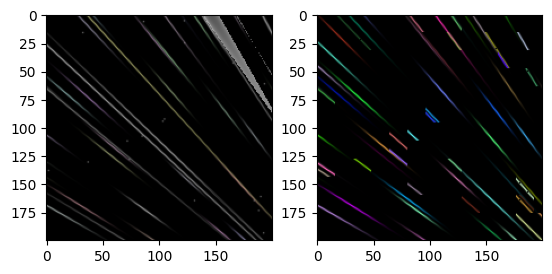

In [33]:
torch.manual_seed(gt_seed)
import random
random.seed(gt_seed)
np.random.seed(gt_seed)

N = 100

means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
opacity = torch.sigmoid(torch.tensor(torch.ones((N,1)), requires_grad=True, device=device))
colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
shs = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
scales = torch.exp(torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device))
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
cov3D_precomp = torch.tensor(0.01 * torch.ones((N,3)), requires_grad=True, device=device)

fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2.0
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2.0
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)
print(tan_fovx, tan_fovy)

camera_pose_jax = jnp.eye(4)
proj_matrix = getProjectionMatrix(0.01, 100.0, fovX, fovY).transpose(0,1).cuda()
view_matrix = torch.transpose(torch.tensor(np.array(jnp.linalg.inv(camera_pose_jax))),0,1).cuda()
projmatrix = view_matrix @ proj_matrix

raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([0.0, 0.0, 0.0]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=projmatrix,
    sh_degree=0,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
# rasterizer = GaussianRasterizerJax(raster_settings=raster_settings)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)

color,radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = shs,
    colors_precomp = None,
    opacities = opacity,
    # scales = scales,
    # rotations = rotations,
    cov3D_precomp=cov3D_precomp
)
# print(colors_precomp_gt)
print(color.min().item(), color.max().item(), color.mean().item())
print('\n')

color_gt = color.detach()
# gt_viz = b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0)
# gt_viz

primitive = _build_rasterize_gaussians_fwd_primitive()
import jax
import jax.numpy as jnp


# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy()[...,:3])

bg = jnp.zeros(3)
means3D = torch_to_jax(means3D)
N = means3D.shape[0]
colors_precomp = torch_to_jax(colors_precomp_gt)
opacities = jnp.ones((N,1))
scales = torch_to_jax(scales)
rotations = torch_to_jax(rotations)
cov3D_precomp = torch_to_jax(cov3D_precomp)
shs = torch_to_jax(shs)
viewmatrix = torch_to_jax(view_matrix)
projmatrix = torch_to_jax(projmatrix)
tanfovx, tanfovy = 0.7499999908297853, 0.7499999908297853
image_height = int(intrinsics.height)
image_width = int(intrinsics.width)
sh_degree = 0
campos = jnp.zeros(3)
image_empty = jnp.zeros((image_height, image_width, 3))

color = primitive.bind(
            bg,
            means3D,
            colors_precomp,
            opacities,
            scales * 10.0,
            rotations,
            cov3D_precomp, 
            viewmatrix,
            projmatrix,
            shs,
            campos,
            image_empty,
            tanfovx, tanfovy, image_height, image_width,  sh_degree
)[1]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy()[...,:3])
ax2.imshow(jnp.transpose(color, (1,2,0))[...,:3])

AttributeError: 'ArrayImpl' object has no attribute 'detach'

In [11]:
projmatrix

Array([[ 3.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  3.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.0001  ,  1.      ],
       [ 0.      ,  0.      , -0.010001,  0.      ]], dtype=float32)

In [10]:
viewmatrix

Array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

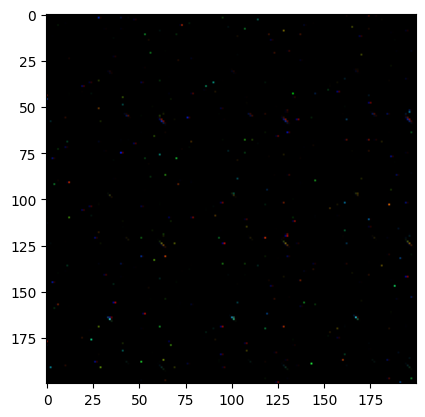

In [71]:
color.sum()

Array(160.29532, dtype=float32)

In [38]:
len([range(0, -1, -1), range(1, -1, -1), range(1, -1, -1), range(0, -1, -1), range(1, -1, -1), range(1, -1, -1), range(1, -1, -1), range(1, -1, -1), range(1, -1, -1), range(-1, -1, -1), range(-1, -1, -1)]
)

11

In [27]:
np.dtype(np.float32)

dtype('float32')

In [ ]:
Invoked with: <jaxlib.mlir._mlir_libs._mlir.ir.BlockArgument object at 0x7fac9959d430>
 <jaxlib.mlir._mlir_libs._mlir.ir.BlockArgument object at 0x7fac9959d4f0>
 <jaxlib.mlir._mlir_libs._mlir.ir.BlockArgument object at 0x7fac9959d5f0>
 100
 <jaxlib.mlir._mlir_libs._mlir.ir.BlockArgument object at 0x7fac9959d2b0>
 <jaxlib.mlir._mlir_libs._mlir.ir.BlockArgument object at 0x7fac9959d3b0>


In [64]:
_C.build_gaussian_rasterize_fwd_descriptor(
    1,1,1,1,1.0, 1.0
)

b'\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x80?\x00\x00\x80?'

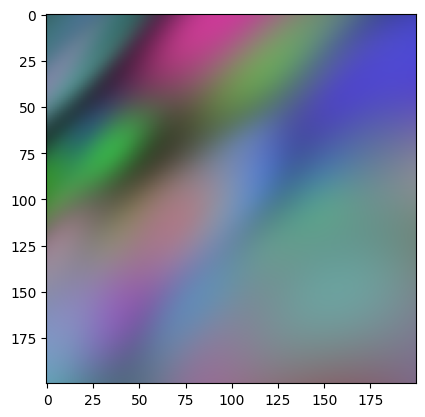

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

/tmp/ipykernel_38831/2454237893.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/tmp/ipykernel_38831/2454237893.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/tmp/ipykernel_38831/2454237893.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
/tmp/ipykernel_388

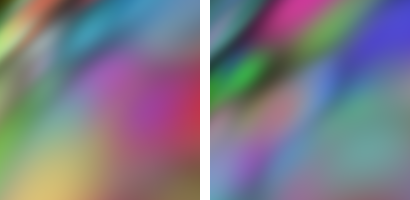

In [ ]:
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

0.004555233754217625: 100%|██████████| 600/600 [00:01<00:00, 323.68it/s] 


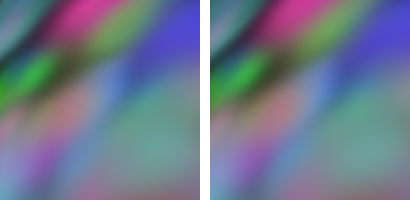

: 

In [ ]:
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

it = 50
pbar = tqdm(range(it))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
    
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])

0.023603683337569237:   6%|▌         | 33/600 [00:00<00:01, 321.45it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.024019213393330574:   6%|▌         | 33/600 [00:00<00:01, 321.45it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02737502008676529:  16%|█▋        | 98/600 [00:00<00:01, 300.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02462419494986534:  16%|█▋        | 98/600 [00:00<00:01, 300.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02426442690193653:  26%|██▋       | 159/600 [00:00<00:01, 296.16it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.026430362835526466:  26%|██▋       | 159/600 [00:00<00:01, 296.16it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.025271646678447723:  36%|███▋      | 219/600 [00:00<00:01, 289.84it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02470501698553562:  36%|███▋      | 219/600 [00:00<00:01, 289.84it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02329275757074356:  46%|████▋     | 278/600 [00:00<00:01, 289.96it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.0231704730540514:  46%|████▋     | 278/600 [00:01<00:01, 289.96it/s]  

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.024434193968772888:  56%|█████▋    | 339/600 [00:01<00:00, 293.67it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.023653533309698105:  56%|█████▋    | 339/600 [00:01<00:00, 293.67it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02446001023054123:  67%|██████▋   | 401/600 [00:01<00:00, 299.64it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.024054573848843575:  67%|██████▋   | 401/600 [00:01<00:00, 299.64it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.027621755376458168:  77%|███████▋  | 463/600 [00:01<00:00, 300.72it/s]

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02791326679289341:  77%|███████▋  | 463/600 [00:01<00:00, 300.72it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.02688293345272541:  88%|████████▊ | 525/600 [00:01<00:00, 300.76it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02510428987443447:  88%|████████▊ | 525/600 [00:01<00:00, 300.76it/s] 

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

0.0254441499710083:  98%|█████████▊| 587/600 [00:01<00:00, 301.68it/s]  

Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering p

0.02420882135629654: 100%|██████████| 600/600 [00:02<00:00, 297.68it/s] 


Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488Entering postprocCHUNK SIZE GEOM 9488
chunk_size = 9488

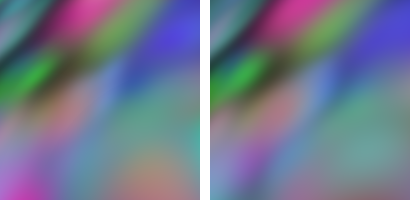

In [ ]:
default_seed = 1
torch.manual_seed(default_seed)
import random
random.seed(default_seed)
np.random.seed(default_seed)

optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

it = 50
pbar = tqdm(range(it))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,:3] * 255.0),
    gt_viz
])